#### 1. 활용 데이터

- 사용 라이브러리 모음

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import koreanize_matplotlib

# 인코더, 스케일러
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Model
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split

from sklearn import preprocessing

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import copy

# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

# Optimization
import lightgbm as lgb
from bayes_opt import BayesianOptimization

- 데이터 불러오기

In [4]:
df = pd.read_csv('./data/churn_data.csv')

- 결측치 확인 및 필요 없는 컬럼 제거

In [5]:
# 결측치 확인
print(df.isnull().sum().sum())

# 필요 없는 컬럼 제거 -> number
df = df.drop(columns = ['number'])

0


- 컬럼명 및 자료형 확인
    - 유저ID, 학년, 성별의 3가지 object 타입 데이터
    - 유저의 행동 이력이 담긴 8가지 float64 타입 데이터
    - 이탈 여부를 0/1로 표기한 int64 타입 데이터
    - 재구매/신규 여부를 True/False로 표기한 bool 타입 데이터

In [1]:
df.info()

#### 2. 데이터 시각화

- 이탈/비이탈 비율 그래프<p>
이탈 비율은 1.55%로 매우 적은 비중을 차지한다.

In [7]:
# 그래프 그리기
fig = px.pie(df, names = 'label')

fig.show()

- 성별에 따른 이탈학생 수 그래프<p>
이탈 비율은 남학생: 1.65%, 여학생: 1.50% 로 남학생이 상대적으로 높았다.

In [8]:
fig = px.histogram(df, x="mbr_sex_cd", text_auto=True,
                 color="label", barmode="group")

fig.show()

- 학년에 따른 이탈학생 수 그래프<p>
이탈 학생의 비율은 6 -> 1 -> 5 -> 4 -> 3 -> 2 순으로 나타났다.

In [89]:
fig = px.histogram(df, x="grade", text_auto=True,
                 color="label", barmode="group")

fig.show()

#### 3. 모델링
---

##### 3-1. 데이터 전처리

- 'grade_sect_cd' 값 -> 1, 2, 3, 4, 5, 6 으로 치환 -> 'grade' 컬럼 구성

In [9]:
def grade(x):
    for i in range(1,7):
        if x == f'G01{i}':
            return i
        
df['grade'] = df['grade_sect_cd'].apply(lambda x: grade(x))

In [6]:
# grade_sect_cd 컬럼은 제거

df2 = df.copy()
df2 = df2.drop(columns = 'grade_sect_cd')

- train, test 데이터 만들기

In [45]:
# encoding
dfm = df2.copy()

encoder = LabelEncoder()
dfm['re_purch'] = encoder.fit_transform(dfm['re_purch'])
dfm['mbr_sex_cd'] = encoder.fit_transform(dfm['mbr_sex_cd'])

# 필요 컬럼만 가져오기 (X : 학습 데이터, y: 레이블)
ID = dfm['system_id']
X = dfm.drop(['label', 'system_id'], axis = 1)
y = dfm['label']

# Train, Test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 777)

##### 3-2. LogisticRegression 모델
- f1 score 0.634로 만족스럽지 않은 결과가 나왔다.

- 스케일링
- 모델 학습 및 예측

In [46]:
# 스케일링
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Logistic 모델 학습
LR = LogisticRegression()
LR.fit(X_train, y_train)

# 예측 및 결과
y_pred = LR.predict(X_test)

y_pred.sum()

74

- Accuracy, Precision, Recall, f1 score 측정

In [47]:
from sklearn.metrics import accuracy_score

accuracy = round(accuracy_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred, average = 'macro'), 3)
recall = round(recall_score(y_test, y_pred, average = 'macro'), 3)
f1 = round(f1_score(y_test, y_pred, average = 'macro'), 3)

print('accuracy : ', accuracy, '\n',
      'precision : ', precision, '\n',
      'recall : ', recall, '\n',
      'f1 : ', f1)

accuracy :  0.985 
 precision :  0.831 
 recall :  0.586 
 f1 :  0.634


- confusion matrix 시각화

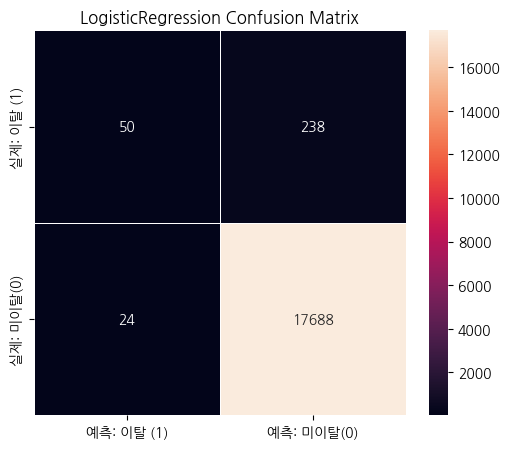

In [48]:
cm = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels = [1, 0]),
    index = ['실제: 이탈 (1)', '실제: 미이탈(0)'],
    columns = ['예측: 이탈 (1)', '예측: 미이탈(0)']
)

plt.figure(figsize = (6, 5))
plt.title('LogisticRegression Confusion Matrix')
sns.heatmap(cm, annot = True, fmt = ".0f", linewidth = .5)
plt.show()

##### 3-3. LGBM 모델
- f1 score 0.922로 별다른 최적화 없이도 높은 예측 결과가 나왔다.

In [49]:
# 데이터 만들기

# encoding
dfm = df2.copy()

encoder = LabelEncoder()
dfm['re_purch'] = encoder.fit_transform(dfm['re_purch'])
dfm['mbr_sex_cd'] = encoder.fit_transform(dfm['mbr_sex_cd'])

# 필요 컬럼만 가져오기 (X : 학습 데이터, y: 레이블)
ID = dfm['system_id']
X = dfm.drop(['label', 'system_id'], axis = 1)
y = dfm['label']

# Train, Test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 777)

- 모델 학습 및 예측

In [50]:
# LGBM 모델 학습
LGBM = LGBMClassifier(random_state = 0, verbose = -1)

LGBM.fit(X_train, y_train)

# 예측 및 결과
y_pred = LGBM.predict(X_test)

y_pred.sum()

255

- Accuracy, Precision, Recall, f1 score 측정

In [51]:
# 예측 결과
accuracy = round(accuracy_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred, average = 'macro'), 3)
recall = round(recall_score(y_test, y_pred, average = 'macro'), 3)
f1 = round(f1_score(y_test, y_pred, average = 'macro'), 3)

print('accuracy : ', accuracy, '\n',
      'precision : ', precision, '\n',
      'recall : ', recall, '\n',
      'f1 : ', f1)

accuracy :  0.995 
 precision :  0.949 
 recall :  0.899 
 f1 :  0.922


- confusion matrix 시각화

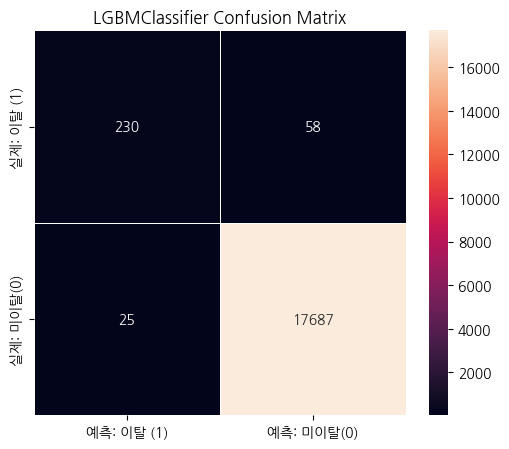

In [52]:
# confusion matrix 시각화

cm = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels = [1, 0]),
    index = ['실제: 이탈 (1)', '실제: 미이탈(0)'],
    columns = ['예측: 이탈 (1)', '예측: 미이탈(0)']
)

plt.figure(figsize = (6, 5))
plt.title('LGBMClassifier Confusion Matrix')
sns.heatmap(cm, annot = True, fmt = ".0f", linewidth = .5)
plt.show()

##### 3-4. 영향도 시각화
- 주요 변수의 영향도를 시각화하여 나타냈다
- 하위의 값 중 범주형에 속하는 mbr_sex_cd, re_purch, grade 세 가지를 범주에 따라 분리하여 각각 모델을 만들어본다.

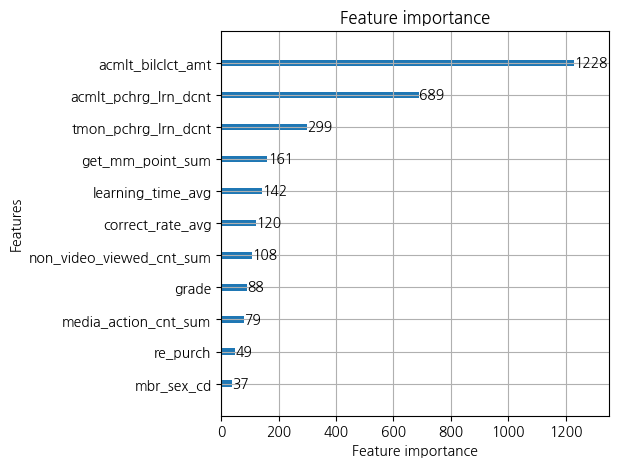

In [54]:
# 영향도 (주요 변수 시각화)
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fix, ax = plt.subplots(figsize = (5, 5))
plot_importance(LGBM, ax = ax)

plt.show()

#### 4. 분리 예측 모델
---
- 데이터를 성별, 신규/재구매, 학년으로 분리하여 각각 모델링하였다.
- f1 score가 비교적 높게 나온 성별과 신규/재구매의 경우 서로를 조합하여 다시 한 번 모델링을 시행했다.

##### 4-1. 성별 분리
- f1 score
    - 여학생: 0.894
    - 남학생: 0.921
    - 성별없음: 0.797
- 분리 전보다 예측 결과가 좋지 않다. 특히 성별이 기록되지 않은 경우 0.8 이하로 떨어졌다.

In [57]:
# 데이터 만들기

# encoding
dfm = df2.copy()

encoder = LabelEncoder()
dfm['re_purch'] = encoder.fit_transform(dfm['re_purch'])
dfm['mbr_sex_cd'] = encoder.fit_transform(dfm['mbr_sex_cd'])

# 필요 컬럼만 가져오기 (X : 학습 데이터, y: 레이블)
ID = dfm['system_id']
X = dfm.drop(['label', 'system_id'], axis = 1)
y = dfm['label']

# Train, Test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 777)

여학생 예측 결과: 
 accuracy :  0.995 
 precision :  0.96 
 recall :  0.845 
 f1 :  0.894


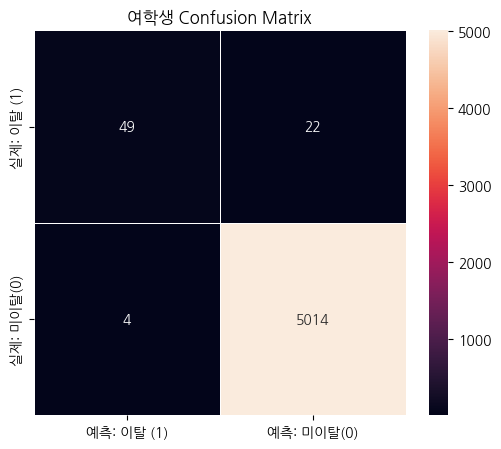

남학생 예측 결과: 
 accuracy :  0.995 
 precision :  0.951 
 recall :  0.895 
 f1 :  0.921


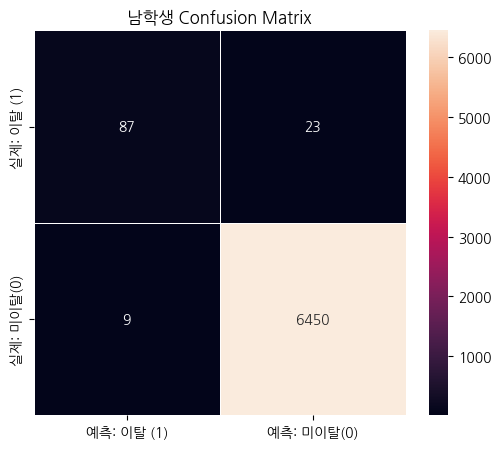

성별 없음 예측 결과: 
 accuracy :  0.988 
 precision :  0.871 
 recall :  0.749 
 f1 :  0.797


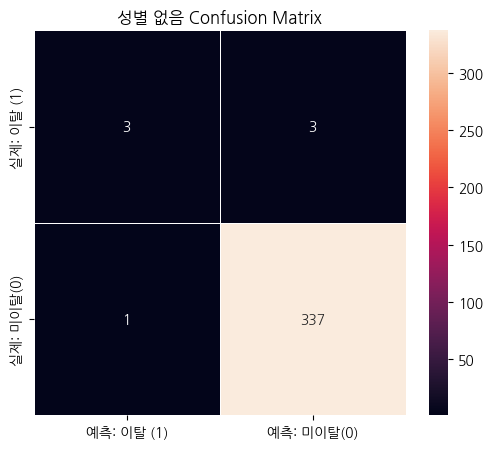

In [58]:
gender = ['여학생', '남학생', '성별 없음']

for i in [0, 1, 2]:
    df_x = dfm[dfm['mbr_sex_cd'] == i]
    
    ID = df_x['system_id']
    X = df_x.drop(['label', 'system_id'], axis = 1)
    y = df_x['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 777)

#     scaler = preprocessing.StandardScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)

    LGBM = LGBMClassifier(random_state = 0, verbose = -1)

    LGBM.fit(X_train, y_train)
    
    y_pred = LGBM.predict(X_test)
    
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred, average = 'macro'), 3)
    recall = round(recall_score(y_test, y_pred, average = 'macro'), 3)
    f1 = round(f1_score(y_test, y_pred, average = 'macro'), 3)

    print(gender[i] + ' 예측 결과: \n',
          'accuracy : ', accuracy, '\n',
          'precision : ', precision, '\n',
          'recall : ', recall, '\n',
          'f1 : ', f1)

    cm = pd.DataFrame(
        confusion_matrix(y_test, y_pred, labels = [1, 0]),
        index = ['실제: 이탈 (1)', '실제: 미이탈(0)'],
        columns = ['예측: 이탈 (1)', '예측: 미이탈(0)']
    )
    
    plt.figure(figsize = (6, 5))
    plt.title(gender[i] + ' Confusion Matrix')
    sns.heatmap(cm, annot = True, fmt = ".0f", linewidth = .5)
    plt.show()

##### 4-2. 신규/재구매 분리
- f1 score
    - 신규: 0.924
    - 재구매: 0.934

- f1 score의 평균이 0.929로 4가지 분리 모델 중 가장 높다. 분리 이전의 f1 score에 비해 0.07 상승했다.

In [60]:
# 데이터 만들기

# encoding
dfm = df2.copy()

encoder = LabelEncoder()
dfm['re_purch'] = encoder.fit_transform(dfm['re_purch'])
dfm['mbr_sex_cd'] = encoder.fit_transform(dfm['mbr_sex_cd'])

# 필요 컬럼만 가져오기 (X : 학습 데이터, y: 레이블)
ID = dfm['system_id']
X = dfm.drop(['label', 'system_id'], axis = 1)
y = dfm['label']

# Train, Test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 777)

신규 예측 결과: 
 accuracy :  0.996 
 precision :  0.942 
 recall :  0.907 
 f1 :  0.924


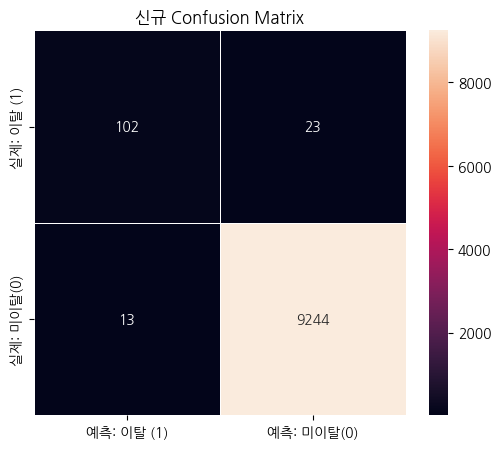

재구매 예측 결과: 
 accuracy :  0.995 
 precision :  0.966 
 recall :  0.907 
 f1 :  0.934


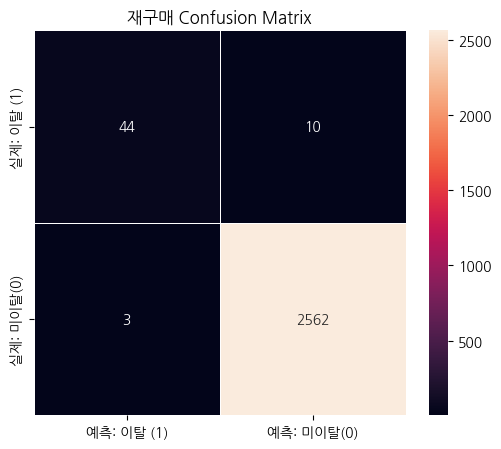

In [61]:
# re_purch: 0 -> False -> 신규

re_purch = ['신규', '재구매']

for i in [0, 1]:
    df_x = dfm[dfm['re_purch'] == i]
    
    ID = df_x['system_id']
    X = df_x.drop(['label', 'system_id'], axis = 1)
    y = df_x['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 777)

    # scaler = preprocessing.StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    LGBM = LGBMClassifier(random_state = 0, verbose = -1)

    LGBM.fit(X_train, y_train)
    
    y_pred = LGBM.predict(X_test)
    
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred, average = 'macro'), 3)
    recall = round(recall_score(y_test, y_pred, average = 'macro'), 3)
    f1 = round(f1_score(y_test, y_pred, average = 'macro'), 3)

    print(re_purch[i] + ' 예측 결과: \n',
          'accuracy : ', accuracy, '\n',
          'precision : ', precision, '\n',
          'recall : ', recall, '\n',
          'f1 : ', f1)

    cm = pd.DataFrame(
        confusion_matrix(y_test, y_pred, labels = [1, 0]),
        index = ['실제: 이탈 (1)', '실제: 미이탈(0)'],
        columns = ['예측: 이탈 (1)', '예측: 미이탈(0)']
    )
    
    plt.figure(figsize = (6, 5))
    plt.title(re_purch[i] + ' Confusion Matrix')
    sns.heatmap(cm, annot = True, fmt = ".0f", linewidth = .5)
    plt.show()

##### 4-3. 학년 분리
- f1 score
    - 1학년: 0.817
    - 2학년: 0.824
    - 3학년: 0.858
    - 4학년: 0.86
    - 5학년: 0.818
    - 6학년: 0.852
- 분리를 한 모델들 중 가장 결과가 좋지 않았다.

In [62]:
# 데이터 만들기

# encoding
dfm = df2.copy()

encoder = LabelEncoder()
dfm['re_purch'] = encoder.fit_transform(dfm['re_purch'])
dfm['mbr_sex_cd'] = encoder.fit_transform(dfm['mbr_sex_cd'])

# 필요 컬럼만 가져오기 (X : 학습 데이터, y: 레이블)
ID = dfm['system_id']
X = dfm.drop(['label', 'system_id'], axis = 1)
y = dfm['label']

# Train, Test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 777)

1학년 예측 결과: 
 accuracy :  0.992 
 precision :  0.854 
 recall :  0.787 
 f1 :  0.817


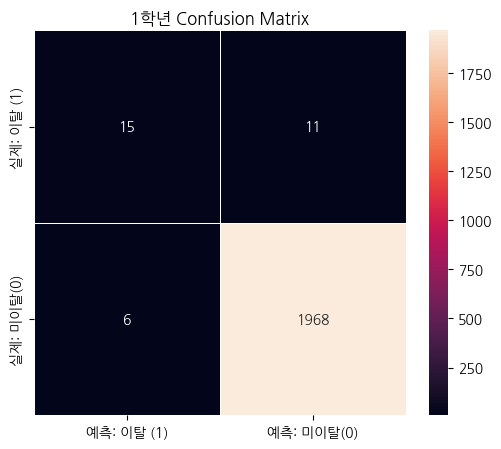

2학년 예측 결과: 
 accuracy :  0.992 
 precision :  0.803 
 recall :  0.848 
 f1 :  0.824


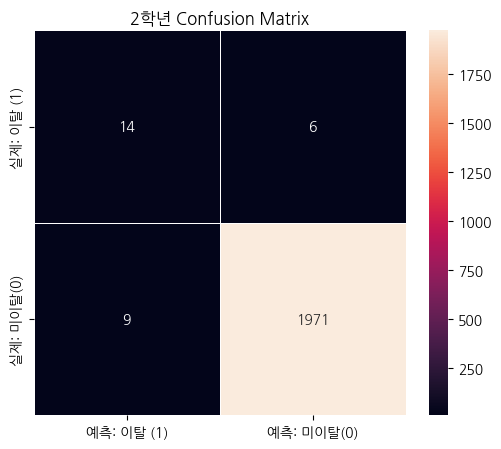

3학년 예측 결과: 
 accuracy :  0.994 
 precision :  0.935 
 recall :  0.804 
 f1 :  0.858


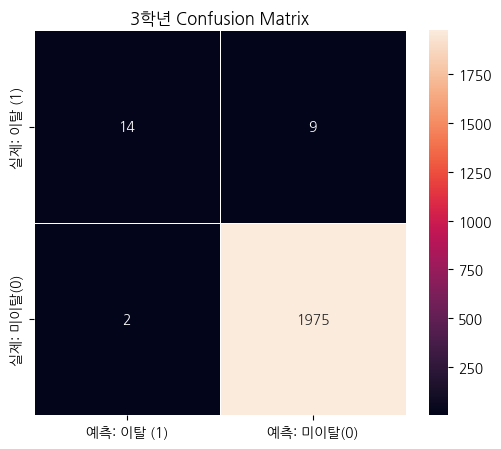

4학년 예측 결과: 
 accuracy :  0.99 
 precision :  0.888 
 recall :  0.836 
 f1 :  0.86


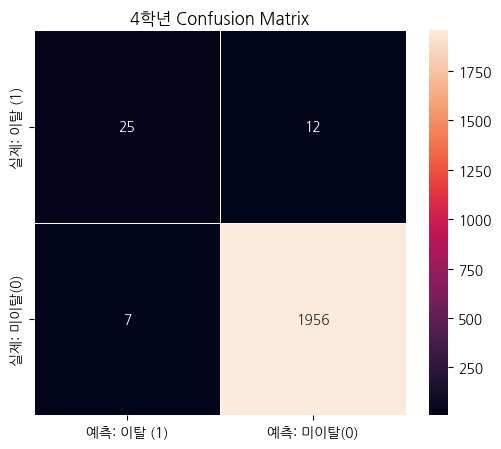

5학년 예측 결과: 
 accuracy :  0.991 
 precision :  0.861 
 recall :  0.784 
 f1 :  0.818


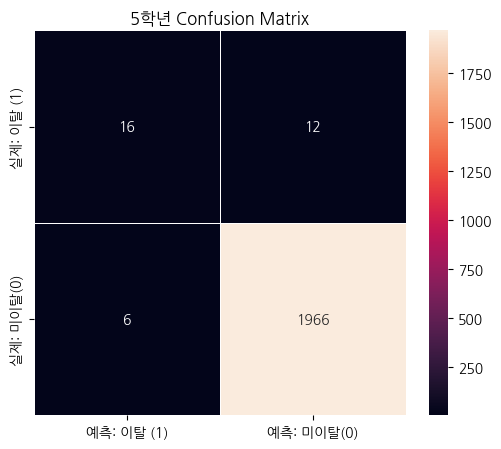

6학년 예측 결과: 
 accuracy :  0.989 
 precision :  0.862 
 recall :  0.844 
 f1 :  0.852


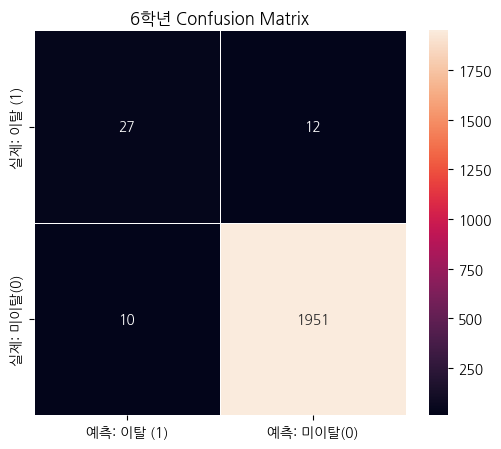

In [63]:
for i in range(1, 7):
    df_x = dfm[dfm['grade'] == i]
    
    ID = df_x['system_id']
    X = df_x.drop(['label', 'system_id'], axis = 1)
    y = df_x['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 777)

    # scaler = preprocessing.StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    LGBM = LGBMClassifier(random_state = 0, verbose = -1)

    LGBM.fit(X_train, y_train)
    
    y_pred = LGBM.predict(X_test)
    
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred, average = 'macro'), 3)
    recall = round(recall_score(y_test, y_pred, average = 'macro'), 3)
    f1 = round(f1_score(y_test, y_pred, average = 'macro'), 3)

    print(f'{i}학년 예측 결과: \n',
          'accuracy : ', accuracy, '\n',
          'precision : ', precision, '\n',
          'recall : ', recall, '\n',
          'f1 : ', f1)
    
    cm = pd.DataFrame(
        confusion_matrix(y_test, y_pred, labels = [1, 0]),
        index = ['실제: 이탈 (1)', '실제: 미이탈(0)'],
        columns = ['예측: 이탈 (1)', '예측: 미이탈(0)']
    )
    
    plt.figure(figsize = (6, 5))
    plt.title(f'{i}학년 Confusion Matrix')
    sns.heatmap(cm, annot = True, fmt = ".0f", linewidth = .5)
    plt.show()

##### 4-4. 신규/재구매, 성별 분리
- f1 score
    - 신규 여학생: 0.909
    - 재구매 여학생: 0.885
    - 신규 남학생: 0.889
    - 재구매 남학생: 0.898
    - 신규 성별없음: 0.696
    - 재구매 성별없음: 1.0
- 성별 분리와 신규/재구매 분리보다 예측 결과가 더 좋지 않다. 데이터가 쪼개질수록 결과가 좋지 않아지는 것으로 보인다.

In [64]:
# 데이터 만들기

# encoding
dfm = df2.copy()

encoder = LabelEncoder()
dfm['re_purch'] = encoder.fit_transform(dfm['re_purch'])
dfm['mbr_sex_cd'] = encoder.fit_transform(dfm['mbr_sex_cd'])

# 필요 컬럼만 가져오기 (X : 학습 데이터, y: 레이블)
ID = dfm['system_id']
X = dfm.drop(['label', 'system_id'], axis = 1)
y = dfm['label']

# Train, Test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 777)

신규 여학생 예측 결과: 
 accuracy :  0.996 
 precision :  0.905 
 recall :  0.914 
 f1 :  0.909


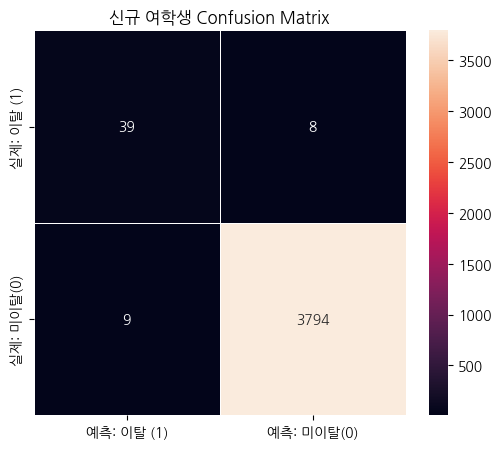

재구매 여학생 예측 결과: 
 accuracy :  0.991 
 precision :  0.949 
 recall :  0.838 
 f1 :  0.885


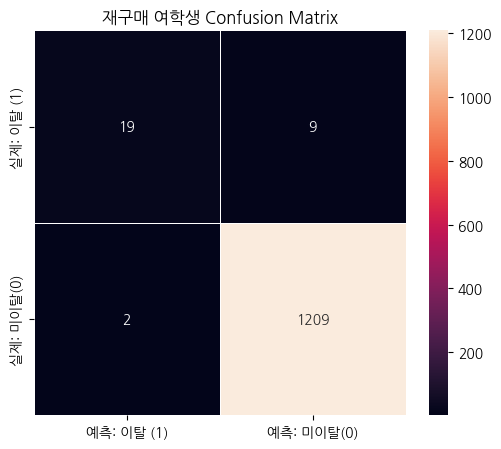

신규 남학생 예측 결과: 
 accuracy :  0.995 
 precision :  0.934 
 recall :  0.852 
 f1 :  0.889


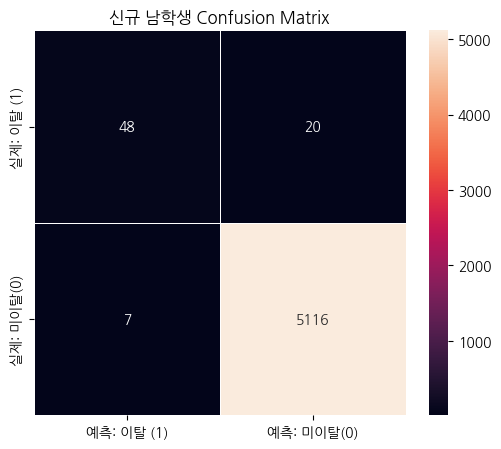

재구매 남학생 예측 결과: 
 accuracy :  0.991 
 precision :  0.916 
 recall :  0.88 
 f1 :  0.898


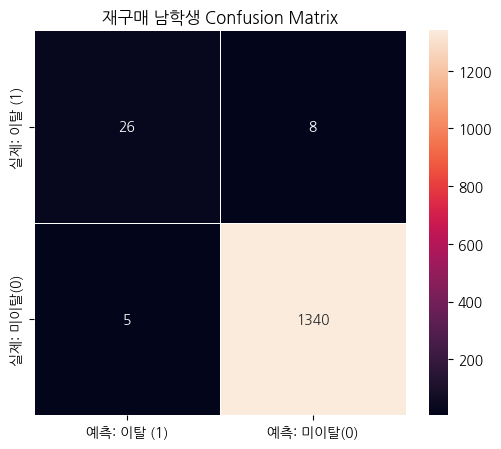

신규 성별 없음 예측 결과: 
 accuracy :  0.982 
 precision :  0.664 
 recall :  0.744 
 f1 :  0.696


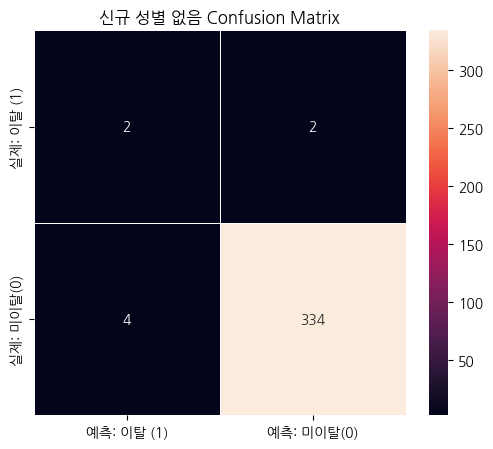

재구매 성별 없음 예측 결과: 
 accuracy :  1.0 
 precision :  1.0 
 recall :  1.0 
 f1 :  1.0


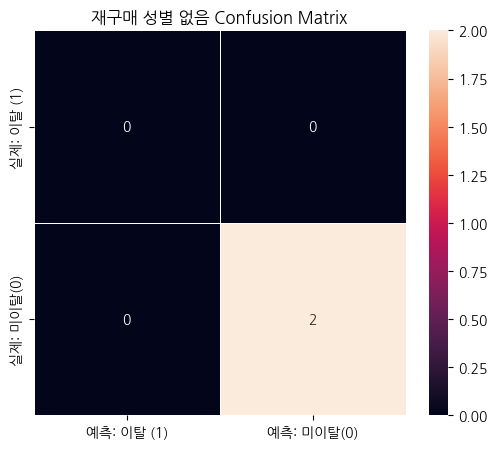

In [65]:
# 0 -> F, 1 -> M, 2 -> X
# re_purch: 0 -> False -> 신규

gender = ['여학생', '남학생', '성별 없음']
re_purch = ['신규', '재구매']

for i in [0, 1, 2]:
    for j in [0, 1]:
        df_x = dfm[dfm['mbr_sex_cd'] == i]
        df_y = df_x[df_x['re_purch'] == j]
        
        ID = df_y['system_id']
        X = df_y.drop(['label', 'system_id'], axis = 1)
        y = df_y['label']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 777)

    #     scaler = preprocessing.StandardScaler()
    #     X_train = scaler.fit_transform(X_train)
    #     X_test = scaler.transform(X_test)

        LGBM = LGBMClassifier(random_state = 0, verbose = -1)

        LGBM.fit(X_train, y_train)
        
        y_pred = LGBM.predict(X_test)
        
        accuracy = round(accuracy_score(y_test, y_pred), 3)
        precision = round(precision_score(y_test, y_pred, average = 'macro'), 3)
        recall = round(recall_score(y_test, y_pred, average = 'macro'), 3)
        f1 = round(f1_score(y_test, y_pred, average = 'macro'), 3)

        print(re_purch[j] + ' ' + gender[i] + ' 예측 결과: \n',
            'accuracy : ', accuracy, '\n',
            'precision : ', precision, '\n',
            'recall : ', recall, '\n',
            'f1 : ', f1)

        cm = pd.DataFrame(
            confusion_matrix(y_test, y_pred, labels = [1, 0]),
            index = ['실제: 이탈 (1)', '실제: 미이탈(0)'],
            columns = ['예측: 이탈 (1)', '예측: 미이탈(0)']
        )
        
        plt.figure(figsize = (6, 5))
        plt.title(re_purch[j] + ' ' + gender[i] + ' Confusion Matrix')
        sns.heatmap(cm, annot = True, fmt = ".0f", linewidth = .5)
        plt.show()

#### 5. 최적화(LGBM Optimization)
---

- 하이퍼파라미터 범주 설정 및 lgbm objective function 설정
    - 'max_depth': (3, 10)
    - 'num_leaves': (10, 30)
    - 'min_child_samples': (10, 30)
    - 'learning_rate': (0.01, 0.5)

In [73]:
# 하이퍼파라미터 범주 설정
param_bayesian = {'max_depth': (3, 10), # 노드의 깊이
                  'num_leaves': (10, 30), # 노드의 개수(넓이)
                  'min_child_samples': (10, 30), # 최소 학습량
                  'learning_rate': (0.01, 0.5)}

def lgbm_objective(num_leaves, learning_rate, max_depth, min_child_samples):
    
    params = {'num_leaves': int(num_leaves),
            'learning_rate': learning_rate,
            'max_depth': int(max_depth),
            'min_child_samples': int(min_child_samples),
            'objective': 'binary',
            'metric': 'binary_logloss',}
    
    # LightGBM 모델 생성 및 학습
    train_data = lgb.Dataset(X_train, label = y_train)
    valid_data = lgb.Dataset(X_test, label = y_test, reference = train_data)
    model = lgb.train(params, train_data, valid_sets = [valid_data])
    
    return -model.best_score['valid_0']['binary_logloss'] 

##### 5-1. 신규/재구매 Optimization
- f1 score
    - 신규: 0.942
    - 재구매: 0.92
- 최적화하기 전에 비해 f1 score의 평균이 0.02 증가했다. 또한 비율이 높은 신규 학생의 예측 결과가 많은 상승을 이루었다는 의의가 있다.

In [74]:
# 데이터 만들기

# encoding
dfm = df2.copy()

encoder = LabelEncoder()
dfm['re_purch'] = encoder.fit_transform(dfm['re_purch'])
dfm['mbr_sex_cd'] = encoder.fit_transform(dfm['mbr_sex_cd'])

# 필요 컬럼만 가져오기 (X : 학습 데이터, y: 레이블)
ID = dfm['system_id']
X = dfm.drop(['label', 'system_id'], axis = 1)
y = dfm['label']

# Train, Test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 777)

|   iter    |  target   | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 514, number of negative: 37012
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1647
[LightGBM] [Info] Number of data points in the train set: 37526, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013697 -> initscore=-4.276774
[LightGBM] [Info] Start training from score -4.276774
| 1         | -0.01282  | 0.1935    | 9.655     | 24.64     | 21.97     |
[LightGBM] [Info] Number of positive: 514, number of negative: 37012
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_row_wise=true` to remove

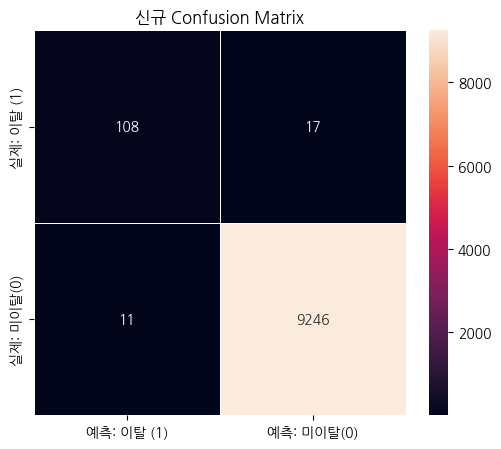

|   iter    |  target   | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 239, number of negative: 10234
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1602
[LightGBM] [Info] Number of data points in the train set: 10473, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022821 -> initscore=-3.757007
[LightGBM] [Info] Start training from score -3.757007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

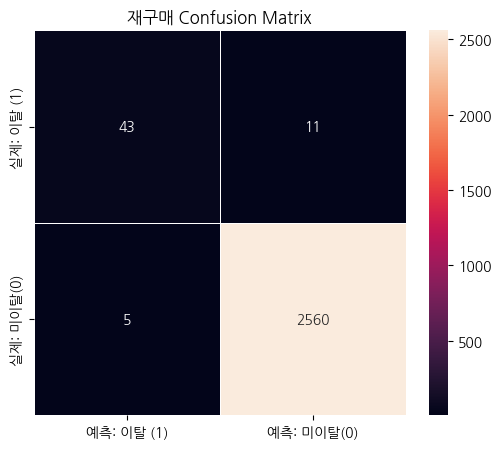

In [75]:
# re_purch: 0 -> False -> 신규

re_purch = ['신규', '재구매']

for i in [0, 1]:
    df_x = dfm[dfm['re_purch'] == i]
    
    ID = df_x['system_id']
    X = df_x.drop(['label', 'system_id'], axis = 1)
    y = df_x['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 777)
    
    # Bayesian Optimization 객체 생성
    optimizer = BayesianOptimization(f = lgbm_objective, pbounds = param_bayesian, random_state = 42)

    # 베이시안 최적화
    optimizer.maximize(init_points = 10, n_iter = 30)

    # 최적의 하이퍼파라미터
    print(optimizer.max)

    # 최적의 하이퍼파라미터로 LGBMClassifier 모델 학습
    best_params = optimizer.max['params']
    best_num_leaves = int(best_params['num_leaves'])
    best_learning_rate = best_params['learning_rate']
    best_max_depth = int(best_params['max_depth'])
    best_min_child_samples = int(best_params['min_child_samples'])

    best_model_bayes = LGBMClassifier(num_leaves= best_num_leaves,
                                learning_rate= best_learning_rate,
                                max_depth= best_max_depth,
                                min_child_samples= best_min_child_samples,
                                objective = 'binary',
                                verbose = -1)

    best_model_bayes.fit(X_train, y_train)

    # 예측 수행
    y_pred = best_model_bayes.predict(X_test)

    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred, average = 'macro'), 3)
    recall = round(recall_score(y_test, y_pred, average = 'macro'), 3)
    f1 = round(f1_score(y_test, y_pred, average = 'macro'), 3)

    print(re_purch[i] + ' 예측 결과: \n',
          'accuracy : ', accuracy, '\n',
          'precision : ', precision, '\n',
          'recall : ', recall, '\n',
          'f1 : ', f1)

    cm = pd.DataFrame(
        confusion_matrix(y_test, y_pred, labels = [1, 0]),
        index = ['실제: 이탈 (1)', '실제: 미이탈(0)'],
        columns = ['예측: 이탈 (1)', '예측: 미이탈(0)']
    )
    
    plt.figure(figsize = (6, 5))
    plt.title(re_purch[i] + ' Confusion Matrix')
    sns.heatmap(cm, annot = True, fmt = ".0f", linewidth = .5)
    plt.show()

##### 5-2. 전체 데이터 Optimization
- f1 score: 0.923
- 최적화 전보다 f1 score가 0.01 높아졌지만 신규/재구매를 분리한 모델에 비해서는 손색이 있다.

In [91]:
# 데이터 만들기

# encoding
dfm = df2.copy()

encoder = LabelEncoder()
dfm['re_purch'] = encoder.fit_transform(dfm['re_purch'])
dfm['mbr_sex_cd'] = encoder.fit_transform(dfm['mbr_sex_cd'])

# 필요 컬럼만 가져오기 (X : 학습 데이터, y: 레이블)
ID = dfm['system_id']
X = dfm.drop(['label', 'system_id'], axis = 1)
y = dfm['label']

# Train, Test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 777)

|   iter    |  target   | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 733, number of negative: 47267
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1658
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015271 -> initscore=-4.166422
[LightGBM] [Info] Start training from score -4.166422
| 1         | -0.01497  | 0.1935    | 9.655     | 24.64     | 21.97     |
[LightGBM] [Info] Number of positive: 733, number of negative: 47267
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_col_wise=true` to remove

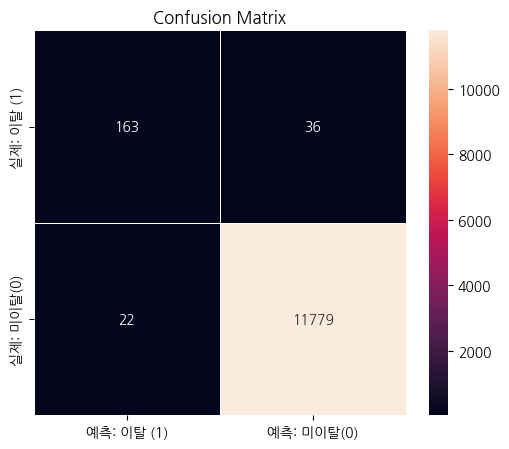

In [92]:
df_x = dfm.copy()

ID = df_x['system_id']
X = df_x.drop(['label', 'system_id'], axis = 1)
y = df_x['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 777)

# Bayesian Optimization 객체 생성
optimizer = BayesianOptimization(f = lgbm_objective, pbounds = param_bayesian, random_state = 42)

# 베이시안 최적화
optimizer.maximize(init_points = 10, n_iter = 30)

# 최적의 하이퍼파라미터
print(optimizer.max)

# 최적의 하이퍼파라미터로 LGBMClassifier 모델 학습
best_params = optimizer.max['params']
best_num_leaves = int(best_params['num_leaves'])
best_learning_rate = best_params['learning_rate']
best_max_depth = int(best_params['max_depth'])
best_min_child_samples = int(best_params['min_child_samples'])

best_model_bayes = LGBMClassifier(num_leaves= best_num_leaves,
                            learning_rate= best_learning_rate,
                            max_depth= best_max_depth,
                            min_child_samples= best_min_child_samples,
                            objective = 'binary',
                            verbose = -1)

best_model_bayes.fit(X_train, y_train)

# 예측 수행
y_pred = best_model_bayes.predict(X_test)

accuracy = round(accuracy_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred, average = 'macro'), 3)
recall = round(recall_score(y_test, y_pred, average = 'macro'), 3)
f1 = round(f1_score(y_test, y_pred, average = 'macro'), 3)

print('예측 결과: \n',
      'accuracy : ', accuracy, '\n',
      'precision : ', precision, '\n',
      'recall : ', recall, '\n',
      'f1 : ', f1)

cm = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels = [1, 0]),
    index = ['실제: 이탈 (1)', '실제: 미이탈(0)'],
    columns = ['예측: 이탈 (1)', '예측: 미이탈(0)']
)

plt.figure(figsize = (6, 5))
plt.title('Confusion Matrix')
sns.heatmap(cm, annot = True, fmt = ".0f", linewidth = .5)
plt.show()